In [1]:
import json 
import os
import os.path as path
from pprint import pprint
import re
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# directories
logs_dir = "../logs"
data_dir = "../data/reddit"
posts_dir = path.join(data_dir, "posts")
comments_dir = path.join(data_dir, "comments")

## Posts

### Scraping overview

In [3]:
# prepwork
filenames = sorted(os.listdir(posts_dir))
filepaths = [path.join(posts_dir, fname) for fname in filenames]
dates = [path.splitext(fname)[0] for fname in filenames]

Number of files: 731
Number of empty files: 44



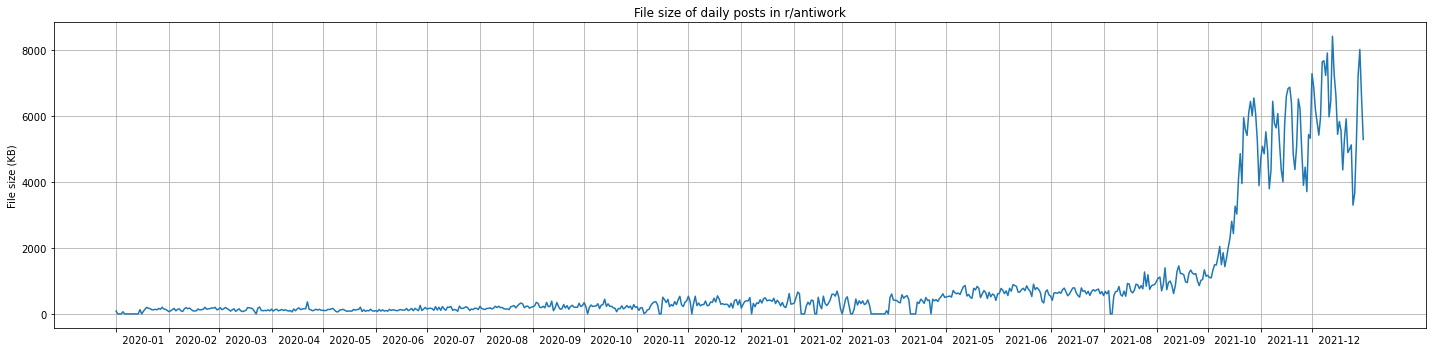

In [4]:
# file sizes
filesizes = np.array([path.getsize(fpath) for fpath in filepaths]) / 1024
print(f"Number of files: {len(filesizes)}")
print(f"Number of empty files: {sum(filesizes == 0)}\n")

if True:
    plt.figure(figsize=(20, 5))
    plt.plot(filesizes)

    plt.title("File size of daily posts in r/antiwork")
    plt.ylabel("File size (KB)")
    plt.tick_params(axis='x')
    plt.xticks(
        ticks=[i for i in range(len(dates)) if dates[i].endswith("01")], 
        labels=["  " + date[:-3] for date in dates if date.endswith("01")], 
        ha="left")
    plt.grid()
    plt.tight_layout()
    plt.show()

### Initial exploration

In [5]:
# peek at sample
with open(filepaths[-1], 'r') as f:
    for line in f:
        x = json.loads(line)
        break
pprint(x)

{'all_awardings': [],
 'allow_live_comments': False,
 'author': 'ClownPrince_1939',
 'author_flair_css_class': None,
 'author_flair_richtext': [],
 'author_flair_text': None,
 'author_flair_type': 'text',
 'author_fullname': 't2_aulum8lp',
 'author_is_blocked': False,
 'author_patreon_flair': False,
 'author_premium': False,
 'awarders': [],
 'can_mod_post': False,
 'contest_mode': False,
 'created_utc': 1640913453,
 'domain': 'self.antiwork',
 'full_link': 'https://www.reddit.com/r/antiwork/comments/rshmro/yall_are_gonna_learn_that_acting_like_a_spiked/',
 'gildings': {},
 'id': 'rshmro',
 'is_created_from_ads_ui': False,
 'is_crosspostable': True,
 'is_meta': False,
 'is_original_content': False,
 'is_reddit_media_domain': False,
 'is_robot_indexable': True,
 'is_self': True,
 'is_video': False,
 'link_flair_background_color': '',
 'link_flair_richtext': [],
 'link_flair_text_color': 'dark',
 'link_flair_type': 'text',
 'locked': False,
 'media_only': False,
 'no_follow': True,
 'num

In [6]:
keys = ['title', 'selftext', 'id', 'author', 'created_utc', 'score']
date_to_posts = {date: [] for date in dates}
date_to_deleted = {date: [] for date in dates}

for date, fpath in tqdm(zip(dates, filepaths)):

    posts = []
    with open(fpath, 'r') as f:
        for line in f:
            x = json.loads(line)
            if 'removed_by_category' in x: 
                date_to_deleted[date].append(x)
            else:
                date_to_posts[date].append({key: x[key] for key in keys})

731it [00:17, 42.04it/s] 


In [7]:
# deleted posts
n_deleted = {date: len(deleted) for date, deleted in date_to_deleted.items()}
_date = max(n_deleted, key=lambda k: n_deleted[k])

print(f"Number of deleted posts: {sum(n_deleted.values())}")
print(f"Max. number of posts deleted from any one date: {max(n_deleted.values())}")
print(f"Creation date with most posts deleted: {_date}\n")
print(f"Titles of deleted/removed posts:")
for post in date_to_deleted[_date][:5]:
    print(f"- {post['title']}")

Number of deleted posts: 8215
Max. number of posts deleted from any one date: 568
Creation date with most posts deleted: 2021-12-08

Titles of deleted/removed posts:
- Generational brainwashing
- Temp Contract Ends and a Urine Screening
- This sub in a nutshell
- Finding my sense of direction
- HELP WANTED: Dealing with a micromanager


Number of posts: 731
Max. number of posts created in one day: 1753


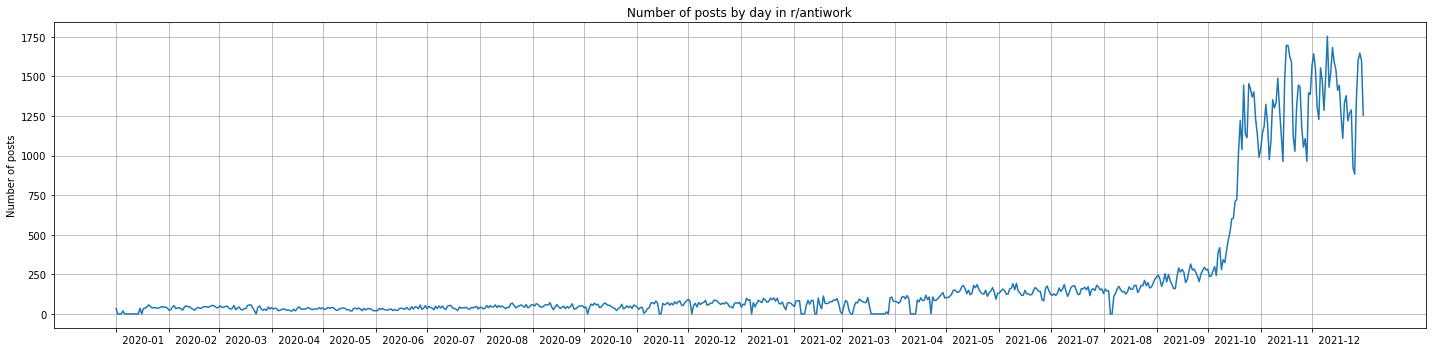

In [8]:
# number of posts by date
n_posts = np.array([len(date_to_posts[date]) for date in dates])
print(f"Number of posts: {len(n_posts)}")
print(f"Max. number of posts created in one day: {n_posts.max()}")

if True:
    plt.figure(figsize=(20, 5))
    plt.plot(n_posts)

    plt.title("Number of posts by day in r/antiwork")
    plt.ylabel("Number of posts")
    plt.tick_params(axis='x')
    plt.xticks(
        ticks=[i for i in range(len(dates)) if dates[i].endswith("01")], 
        labels=["  " + date[:-3] for date in dates if date.endswith("01")], 
        ha="left")
    plt.grid()
    plt.tight_layout()
    plt.show()